In [1]:
import os, subprocess
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity

#This is my relative path
TRAILER_ROOT     = os.path.expanduser("~/Downloads/trailers")
audio_output_dir = os.path.expanduser("~/derivatives/audio")
FEATURE_DIR      = os.path.join(audio_output_dir, "features")

chunk_duration = 0.96 
window_secs    = 15
step_secs      = 5
window_size    = int(window_secs / chunk_duration)
step_size      = int(step_secs   / chunk_duration)

os.makedirs(audio_output_dir, exist_ok=True)
os.makedirs(FEATURE_DIR,   exist_ok=True)


In [2]:
def extract_audio(video_path, wav_path):
    subprocess.run([
    "/opt/homebrew/bin/ffmpeg", "-i", video_path,
    "-ar", "16000", "-ac", "1",
    "-y", wav_path
], check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

for vf in sorted(os.listdir(TRAILER_ROOT)):
    if not vf.lower().endswith(".mp4"):
        continue
    wav_name = vf.rsplit(".", 1)[0] + ".wav"
    wav_path = os.path.join(audio_output_dir, wav_name)
    if not os.path.exists(wav_path):
        print("Extracting audio:", vf)
        extract_audio(os.path.join(TRAILER_ROOT, vf), wav_path)
    else:
        print("Audio exists, skipping:", vf)

print("Audio extraction done")


Extracting audio: A_Quiet_Place_Day1.mp4
Extracting audio: Alien_Romulus.mp4
Extracting audio: BEETLEJUICE_BEETLEJUICE.mp4
Extracting audio: BLINK_TWICE.mp4
Extracting audio: Borderlands.mp4
Extracting audio: CUCKOO.mp4
Extracting audio: Deadpool_Wolverine.mp4
Extracting audio: Despicable_Me_4.mp4
Extracting audio: Fly_Me_To_The_Moon.mp4
Extracting audio: GLADIATOR_2 NEEDS EDIT.mp4
Extracting audio: GLADIATOR_2.mp4
Extracting audio: HAROLD_PURPLE_CRAYON NEEDS EDIT.mp4
Extracting audio: HAROLD_PURPLE_CRAYON.mp4
Extracting audio: Inside_Out_2.mp4
Extracting audio: Joker_Folie_Deux.mp4
Extracting audio: KRAVEN_HUNTER NEEDS EDIT.mp4
Extracting audio: KRAVEN_HUNTER.mp4
Extracting audio: LEE.mp4
Extracting audio: Longlegs.mp4
Extracting audio: MOANA_2 NEEDS EDIT.mp4
Extracting audio: MOANA_2.mp4
Extracting audio: SONIC_3 NEEDS EDIT.mp4
Extracting audio: SONIC_3.mp4
Extracting audio: Speak_No_Evil.mp4
Extracting audio: TWISTERS.mp4
Extracting audio: The_Crow.mp4
Extracting audio: The_Instigat

In [3]:
print("Loading VGGish model")
vggish = hub.load(os.path.expanduser("~/tfhub_modules/google_vggish_1"))

def extract_vggish_features(wav_path):
    audio, _ = librosa.load(wav_path, sr=16000)
    emb = vggish(tf.convert_to_tensor(audio, tf.float32)).numpy()
    return emb

for wav_file in sorted(os.listdir(audio_output_dir)):
    if not wav_file.lower().endswith(".wav"):
        continue

    feature_file = wav_file.replace(".wav", "_features.npy")
    out_path     = os.path.join(FEATURE_DIR, feature_file)

    if not os.path.exists(out_path):
        print("  ↳ Extracting features for", wav_file)
        feats = extract_vggish_features(os.path.join(audio_output_dir, wav_file))
        np.save(out_path, feats)
    else:
        print("Features already exist, skipping:", wav_file)

print("VGGish feature extraction done")

Loading VGGish model
  ↳ Extracting features for A_Quiet_Place_Day1.wav
  ↳ Extracting features for Alien_Romulus.wav
  ↳ Extracting features for BEETLEJUICE_BEETLEJUICE.wav
  ↳ Extracting features for BLINK_TWICE.wav
  ↳ Extracting features for Borderlands.wav
  ↳ Extracting features for CUCKOO.wav
  ↳ Extracting features for Deadpool_Wolverine.wav
  ↳ Extracting features for Despicable_Me_4.wav
  ↳ Extracting features for Fly_Me_To_The_Moon.wav
  ↳ Extracting features for GLADIATOR_2 NEEDS EDIT.wav
  ↳ Extracting features for GLADIATOR_2.wav
  ↳ Extracting features for HAROLD_PURPLE_CRAYON NEEDS EDIT.wav
  ↳ Extracting features for HAROLD_PURPLE_CRAYON.wav
  ↳ Extracting features for Inside_Out_2.wav
  ↳ Extracting features for Joker_Folie_Deux.wav
  ↳ Extracting features for KRAVEN_HUNTER NEEDS EDIT.wav
  ↳ Extracting features for KRAVEN_HUNTER.wav
  ↳ Extracting features for LEE.wav
  ↳ Extracting features for Longlegs.wav
  ↳ Extracting features for MOANA_2 NEEDS EDIT.wav
  ↳ Extr

In [4]:
trailer_features = {}
for fn in sorted(os.listdir(FEATURE_DIR)):
    if fn.endswith("_features.npy"):
        trailer_id = fn[:-13]
        path = os.path.join(FEATURE_DIR, fn)
        trailer_features[trailer_id] = np.load(path)
        
print(f"Loaded features for {len(trailer_features)} trailers.")
for tid, arr in trailer_features.items():
    print(f"  • {tid}: {arr.shape}")


Loaded features for 32 trailers.
  • A_Quiet_Place_Day1: (102, 128)
  • Alien_Romulus: (65, 128)
  • BEETLEJUICE_BEETLEJUICE: (79, 128)
  • BLINK_TWICE: (167, 128)
  • Borderlands: (180, 128)
  • CUCKOO: (149, 128)
  • Deadpool_Wolverine: (165, 128)
  • Despicable_Me_4: (152, 128)
  • Fly_Me_To_The_Moon: (150, 128)
  • GLADIATOR_2 NEEDS EDIT: (87, 128)
  • GLADIATOR_2: (76, 128)
  • HAROLD_PURPLE_CRAYON NEEDS EDIT: (134, 128)
  • HAROLD_PURPLE_CRAYON: (127, 128)
  • Inside_Out_2: (150, 128)
  • Joker_Folie_Deux: (150, 128)
  • KRAVEN_HUNTER NEEDS EDIT: (196, 128)
  • KRAVEN_HUNTER: (189, 128)
  • LEE: (67, 128)
  • Longlegs: (88, 128)
  • MOANA_2 NEEDS EDIT: (88, 128)
  • MOANA_2: (74, 128)
  • SONIC_3 NEEDS EDIT: (102, 128)
  • SONIC_3: (91, 128)
  • Speak_No_Evil: (182, 128)
  • TWISTERS: (124, 128)
  • The_Crow: (186, 128)
  • The_Instigator NEEDS EDITmp4: (80, 128)
  • The_Instigator: (70, 128)
  • VENOM_3 NEEDS EDIT: (104, 128)
  • VENOM_3: (90, 128)
  • White_Bird: (140, 128)
  •

In [5]:
def sliding_indices(n, w, s):
    return range(0, n - w + 1, s)

records = []
ids = list(trailer_features.keys())

for i, t1 in enumerate(ids):
    arr1, n1 = trailer_features[t1], trailer_features[t1].shape[0]
    for j in range(i+1, len(ids)):
        t2, arr2, n2 = ids[j], trailer_features[ids[j]], trailer_features[ids[j]].shape[0]
        for start1 in sliding_indices(n1, window_size, step_size):
            seg1 = arr1[start1:start1+window_size].flatten().reshape(1, -1)
            for start2 in sliding_indices(n2, window_size, step_size):
                seg2 = arr2[start2:start2+window_size].flatten().reshape(1, -1)
                r = cosine_similarity(seg1, seg2)[0, 0]
                z= np.arctanh(np.clip(r, -0.999999, 0.999999))
                records.append({
                    "trailer1":    t1,
                    "trailer2":    t2,
                    "t1_start_s":  round(start1 * chunk_duration, 2),
                    "t2_start_s":  round(start2 * chunk_duration, 2),
                    "sim_z":       z
                })

df = pd.DataFrame.from_records(records)
csv_path = os.path.join(audio_output_dir, "trailer_pair_similarity.csv")
df.to_csv(csv_path, index=False)

print(f"Computed {len(df)} windowed comparisons.")
print("Saved table at ", csv_path)


Computed 234849 windowed comparisons.
Saved table at  /Users/aarondumas/derivatives/audio/trailer_pair_similarity.csv


In [6]:
best = (
    df.groupby(["trailer1","trailer2"])["sim_z"]
      .mean()
      .reset_index()
      .sort_values(["trailer1","sim_z"], ascending=[True,False])
      .groupby("trailer1").first()
      .reset_index()
)

print("Top match for each trailer")
print(best.to_string(index=False))


Top match for each trailer
                       trailer1             trailer2    sim_z
             A_Quiet_Place_Day1             Longlegs 0.638395
                  Alien_Romulus             Longlegs 0.711575
        BEETLEJUICE_BEETLEJUICE             Longlegs 0.589704
                    BLINK_TWICE   Fly_Me_To_The_Moon 0.570854
                    Borderlands               Wicked 0.583314
                         CUCKOO             Longlegs 0.558050
             Deadpool_Wolverine             The_Crow 0.546077
                Despicable_Me_4         Inside_Out_2 0.586802
             Fly_Me_To_The_Moon        Speak_No_Evil 0.566023
                    GLADIATOR_2             Longlegs 0.690129
         GLADIATOR_2 NEEDS EDIT          GLADIATOR_2 1.088549
           HAROLD_PURPLE_CRAYON             Longlegs 0.658923
HAROLD_PURPLE_CRAYON NEEDS EDIT HAROLD_PURPLE_CRAYON 0.895181
                   Inside_Out_2               Wicked 0.541077
               Joker_Folie_Deux            

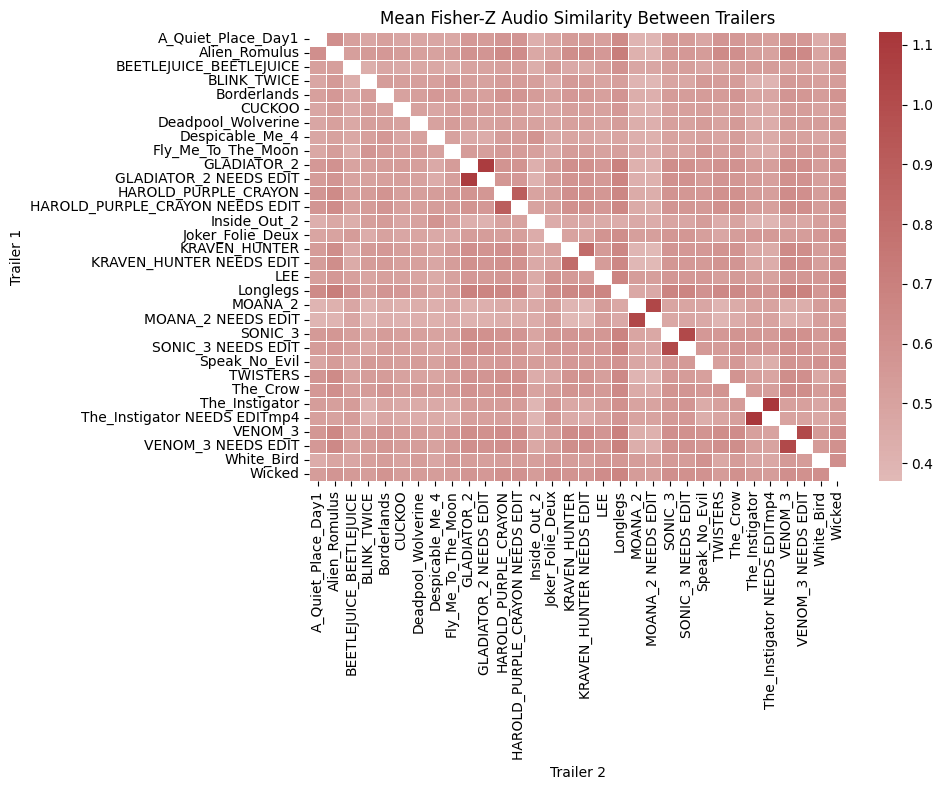

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_df = df.groupby(["trailer1","trailer2"])["sim_z"].mean().reset_index()
rev = mean_df.rename(columns={"trailer1":"trailer2","trailer2":"trailer1"})
full = pd.concat([mean_df, rev], ignore_index=True)

mat = full.pivot(index="trailer1", columns="trailer2", values="sim_z")

plt.figure(figsize=(10,8))
sns.heatmap(mat, cmap="vlag", center=0, linewidths=0.5, annot=False)
plt.title("Mean Fisher-Z Audio Similarity Between Trailers")
plt.xlabel("Trailer 2")
plt.ylabel("Trailer 1")
plt.tight_layout()
plt.show()


In [8]:
import os
np.complex = complex
import librosa
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

audio_output_dir = os.path.expanduser("~/derivatives/audio")

def raw_feature_means(audio_path):
    """Extract mean values for 9 audio features from a WAV file."""
    y, sr = librosa.load(audio_path, sr=16000)
    return {
        "mfcc_mean":      np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)),
        "centroid_mean":  np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "bandwidth_mean": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        "contrast_mean":  np.mean(librosa.feature.spectral_contrast(y=y, sr=sr)),
        "flatness_mean":  np.mean(librosa.feature.spectral_flatness(y=y)),
        "rms_mean":       np.mean(librosa.feature.rms(y=y)),
        "zcr_mean":       np.mean(librosa.feature.zero_crossing_rate(y=y)),
        "chroma_mean":    np.mean(librosa.feature.chroma_stft(y=y, sr=sr)),
        "tonnetz_mean":   np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr))
    }

records = []
for fname in sorted(os.listdir(audio_output_dir)):
    if not fname.lower().endswith(".wav"):
        continue
    base = os.path.splitext(fname)[0]
    feats = raw_feature_means(os.path.join(audio_output_dir, fname))
    feats["trailer"] = base
    records.append(feats)

df_audio = pd.DataFrame(records).set_index("trailer")
df_audio

mfcc_mean  centroid_mean  bandwidth_mean  \
trailer                                                                     
A_Quiet_Place_Day1                0.034861    1318.483860     1508.962155   
Alien_Romulus                     0.529794    1483.269612     1645.314521   
BEETLEJUICE_BEETLEJUICE          -5.205763    1396.516140     1445.567100   
BLINK_TWICE                      -3.115579    1627.447390     1678.360742   
Borderlands                       4.148305    1624.197849     1846.699041   
CUCKOO                           -8.428326    1520.189841     1534.334836   
Deadpool_Wolverine                0.167448    1686.921952     1752.987097   
Despicable_Me_4                   1.304770    1813.855185     1860.784203   
Fly_Me_To_The_Moon               -2.491565    1768.977601     1798.777360   
GLADIATOR_2 NEEDS EDIT           -0.850619     987.284418     1295.784332   
GLADIATOR_2                      -0.568999    1014.351537     1314.481054   
HAROLD_PURPLE_CRAYON NEEDS EDIT   0.134963    1555.603844     1661.655691   
HAROLD_PURPLE_CRAYON              2.362455    1643.702482     1755.403423   
Inside_Out_2                     -3.327639    1993.676231     1804.100019   
Joker_Folie_Deux                 -4.961603    1305.591465     1422.895765   
KRAVEN_HUNTER NEEDS EDIT         -5.732019    1556.361751     1668.070155   
KRAVEN_HUNTER                    -4.094738    1615.159463     1731.088093   
LEE                              -1.707453    1148.139987     1355.431662   
Longlegs                         -1.211991    1028.225654     1261.333558   
MOANA_2 NEEDS EDIT                0.395440    1411.399534     1683.705154   
MOANA_2                           1.824815    1598.190900     1866.216012   
SONIC_3 NEEDS EDIT                0.903184    1343.610116     1407.978868   
SONIC_3                           1.383219    1411.725898     1440.198553   
Speak_No_Evil                    -2.323858    1225.493606     1421.201902   
TWISTERS                          4.844020    1154.190692     1579.111882   
The_Crow                          5.559083    1398.119336     1738.613697   
The_Instigator NEEDS EDITmp4      9.216790    1749.614720     1883.508845   
The_Instigator                   10.124103    1778.302299     1906.429706   
VENOM_3 NEEDS EDIT                0.667074    1157.115621     1509.008061   
VENOM_3                           2.129804    1229.706345     1584.098137   
White_Bird                        2.515411    1380.024231     1673.243226   
Wicked                            5.092772    1378.918711     1706.846061   

                                 contrast_mean  flatness_mean  rms_mean  \
trailer                                                                   
A_Quiet_Place_Day1                   17.161893       0.020944  0.139436   
Alien_Romulus                        17.258389       0.041253  0.103926   
BEETLEJUICE_BEETLEJUICE              20.002325       0.040934  0.117021   
BLINK_TWICE                          17.731066       0.033784  0.088664   
Borderlands                          16.887346       0.022922  0.133026   
CUCKOO                               18.468202       0.038924  0.075538   
Deadpool_Wolverine                   18.349183       0.038183  0.114586   
Despicable_Me_4                      17.216040       0.047557  0.133732   
Fly_Me_To_The_Moon                   17.432054       0.040969  0.076832   
GLADIATOR_2 NEEDS EDIT               17.703558       0.023701  0.081161   
GLADIATOR_2                          16.978274       0.023428  0.081846   
HAROLD_PURPLE_CRAYON NEEDS EDIT      17.250548       0.091108  0.096285   
HAROLD_PURPLE_CRAYON                 17.404149       0.039902  0.101791   
Inside_Out_2                         19.365126       0.047386  0.126895   
Joker_Folie_Deux                     19.751011       0.026942  0.094134   
KRAVEN_HUNTER NEEDS EDIT             16.512102       0.073683  0.040146   
KRAVEN_HUNTER                        16.665440       0.038687  0

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

X = df_audio[["centroid_mean","bandwidth_mean"]].values
sim_2d = cosine_similarity(X)
sim_df_2d = pd.DataFrame(sim_2d, index=df_audio.index, columns=df_audio.index)
sim_df_2d

trailer                          A_Quiet_Place_Day1  Alien_Romulus  \
trailer                                                              
A_Quiet_Place_Day1                         1.000000       0.999880   
Alien_Romulus                              0.999880       1.000000   
BEETLEJUICE_BEETLEJUICE                    0.998750       0.999405   
BLINK_TWICE                                0.998655       0.999339   
Borderlands                                0.999995       0.999925   
CUCKOO                                     0.998039       0.998890   
Deadpool_Wolverine                         0.998845       0.999470   
Despicable_Me_4                            0.998515       0.999240   
Fly_Me_To_The_Moon                         0.998265       0.999059   
GLADIATOR_2 NEEDS EDIT                     0.997753       0.996594   
GLADIATOR_2                                0.998146       0.997081   
HAROLD_PURPLE_CRAYON NEEDS EDIT            0.999411       0.999823   
HAROLD_PURPLE_CRAYON                       0.999408       0.999821   
Inside_Out_2                               0.993147       0.994841   
Joker_Folie_Deux                           0.999705       0.999961   
KRAVEN_HUNTER NEEDS EDIT                   0.999468       0.999853   
KRAVEN_HUNTER                              0.999468       0.999853   
LEE                                        0.999882       0.999524   
Longlegs                                   0.999415       0.998764   
MOANA_2 NEEDS EDIT                         0.999790       0.999352   
MOANA_2                                    0.999951       0.999676   
SONIC_3 NEEDS EDIT                         0.999038       0.999598   
SONIC_3                                    0.998360       0.999128   
Speak_No_Evil                              0.999979       0.999757   
TWISTERS                                   0.996221       0.994754   
The_Crow                                   0.999165       0.998411   
The_Instigator NEEDS EDITmp4               0.999537       0.999889   
The_Instigator                             0.999472       0.999856   
VENOM_3 NEEDS EDIT                         0.997955       0.996843   
VENOM_3                                    0.998317       0.997297   
White_Bird                                 0.999595       0.999033   
Wicked                                     0.999255       0.998536   

trailer                          BEETLEJUICE_BEETLEJUICE  BLINK_TWICE  \
trailer                                                                 
A_Quiet_Place_Day1                              0.998750     0.998655   
Alien_Romulus                                   0.999405     0.999339   
BEETLEJUICE_BEETLEJUICE                         1.000000     0.999998   
BLINK_TWICE                                     0.999998     1.000000   
Borderlands                                     0.998907     0.998818   
CUCKOO                                          0.999920     0.999942   
Deadpool_Wolverine                              0.999998     0.999993   
Despicable_Me_4                                 0.999990     0.999997   
Fly_Me_To_The_Moon                              0.999960     0.999975   
GLADIATOR_2 NEEDS EDIT                          0.993157     0.992938   
GLADIATOR_2                                     0.993856     0.993648   
HAROLD_PURPLE_CRAYON NEEDS EDIT                 0.999877     0.999846   
HAROLD_PURPLE_CRAYON                            0.999878     0.999848   
Inside_Out_2                                    0.997747     0.997870   
Joker_Folie_Deux                                0.999670     0.999620   
KRAVEN_HUNTER NEEDS EDIT                        0.999849     0.999815   
KRAVEN_HUNTER                                   0.999849     0.999815   
LEE                                             0.997865     0.997742   
Longlegs                                        0.996457     0.996299   
MOANA_2 NEEDS EDIT                              0.997516     0.997384   
MOANA_2      

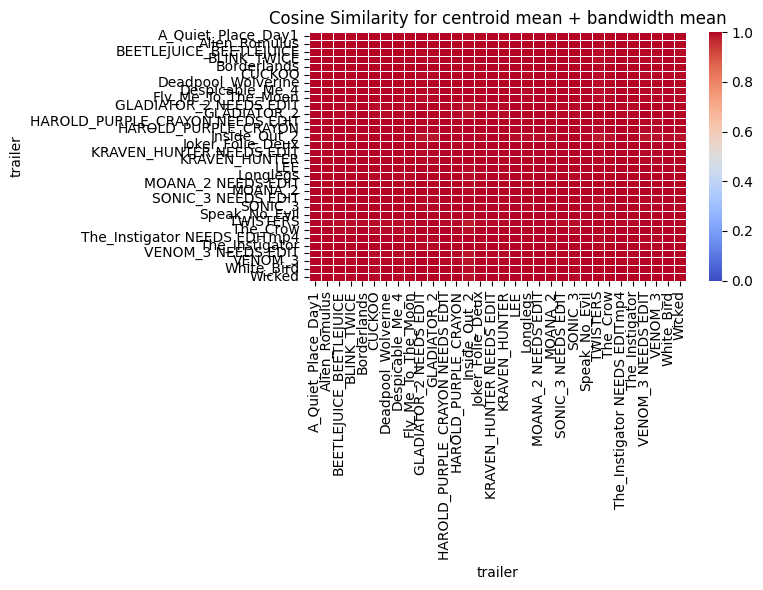

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(sim_df_2d, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("Cosine Similarity for centroid mean + bandwidth mean")
plt.tight_layout()
plt.show()

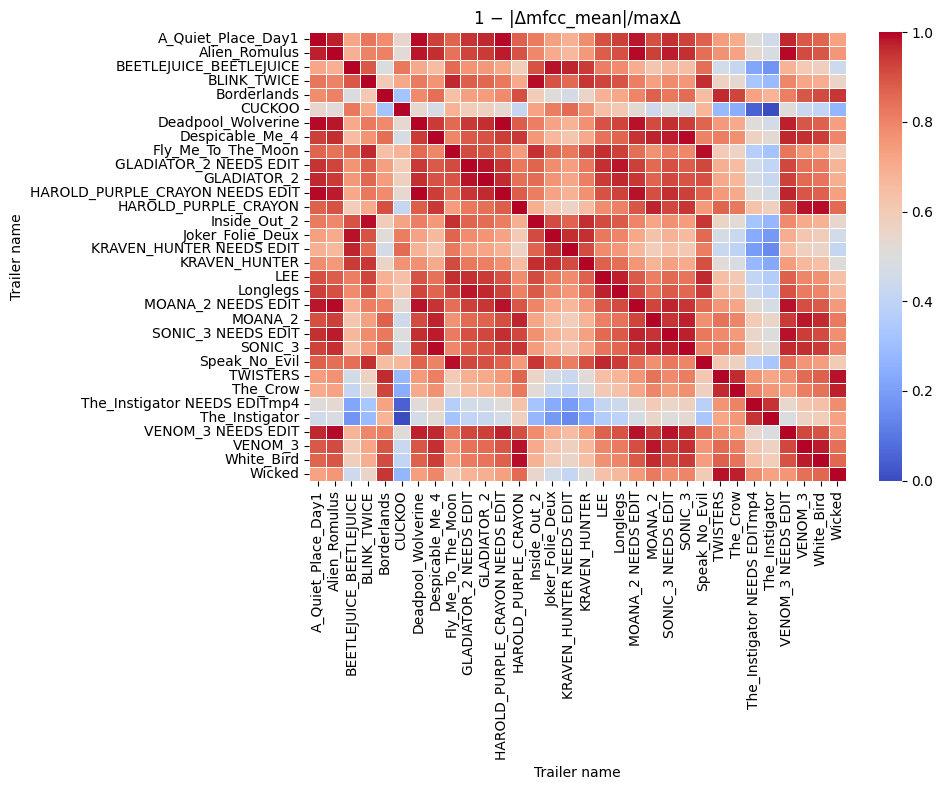

In [11]:
feat = "mfcc_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δmfcc_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

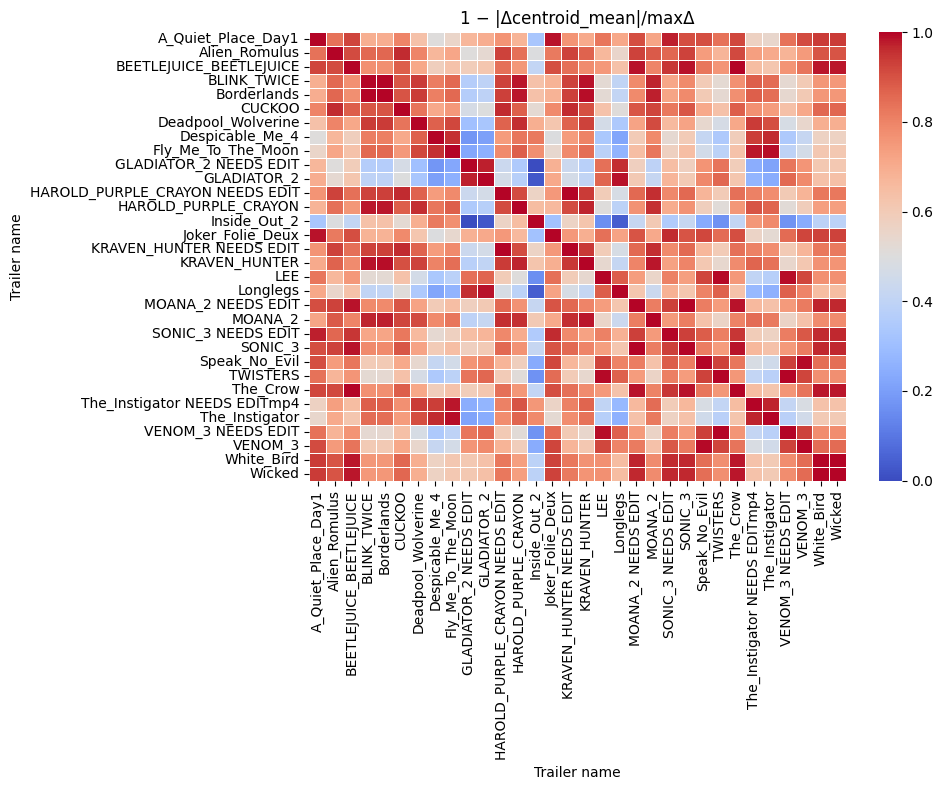

In [12]:
feat = "centroid_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δcentroid_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

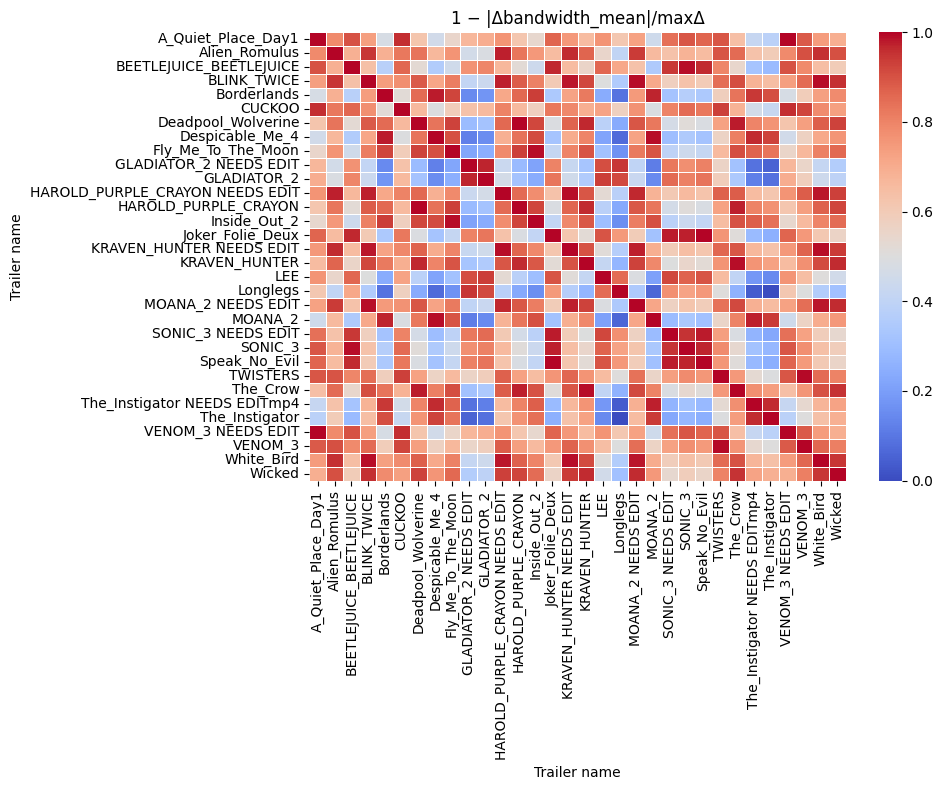

In [13]:
feat = "bandwidth_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δbandwidth_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

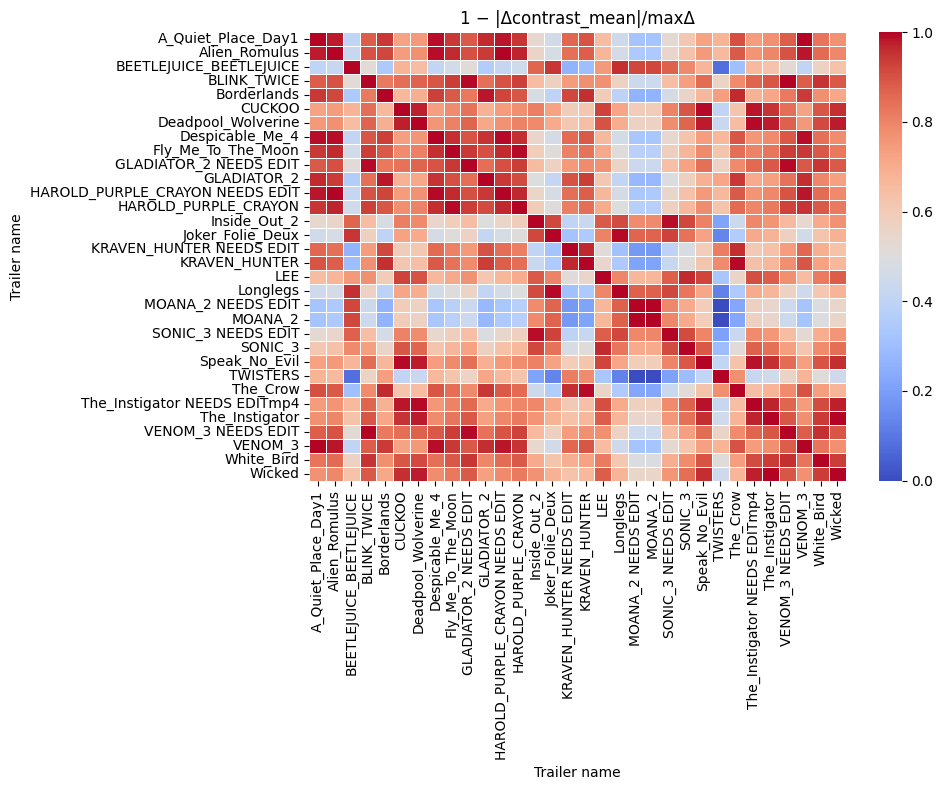

In [14]:
feat = "contrast_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δcontrast_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

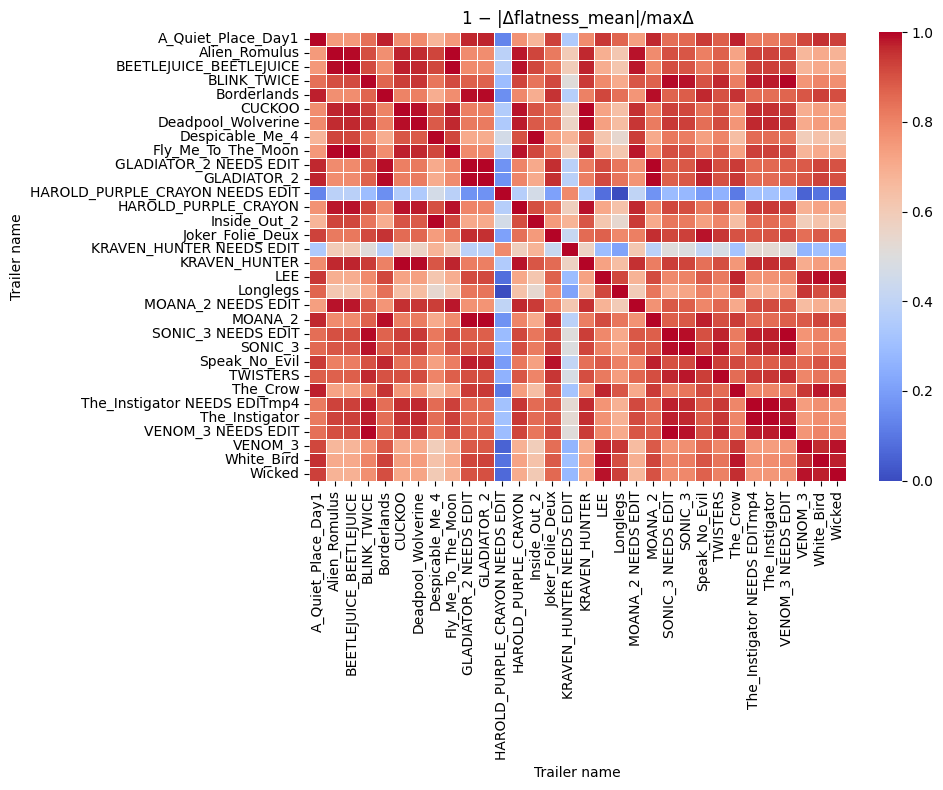

In [15]:
feat = "flatness_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δflatness_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

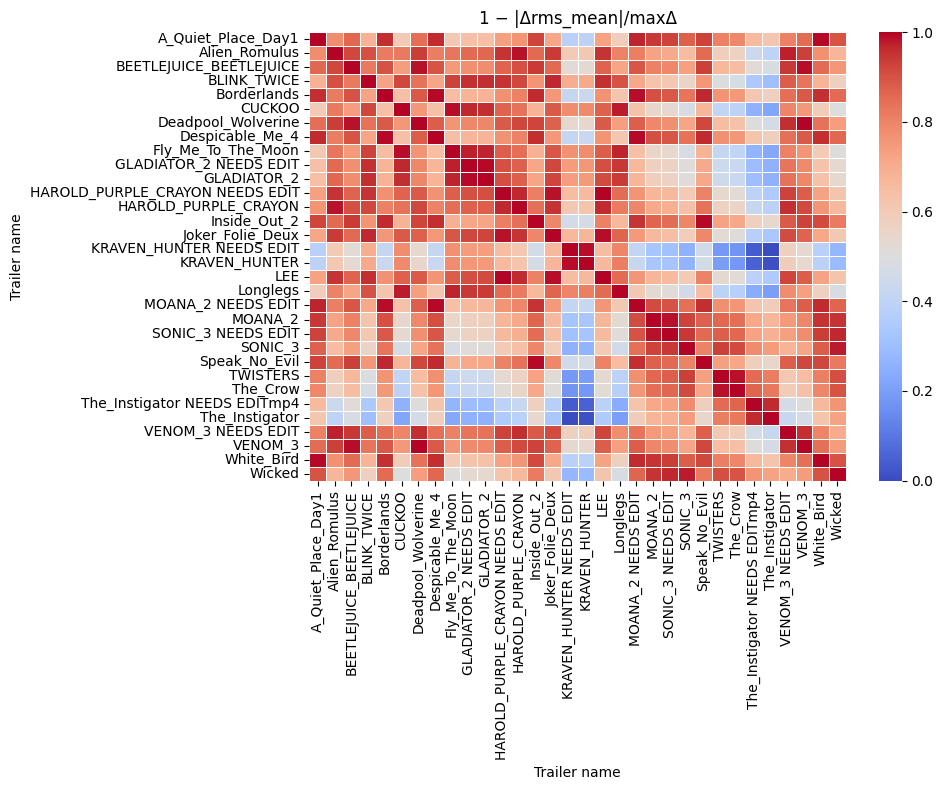

In [16]:
feat = "rms_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δrms_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

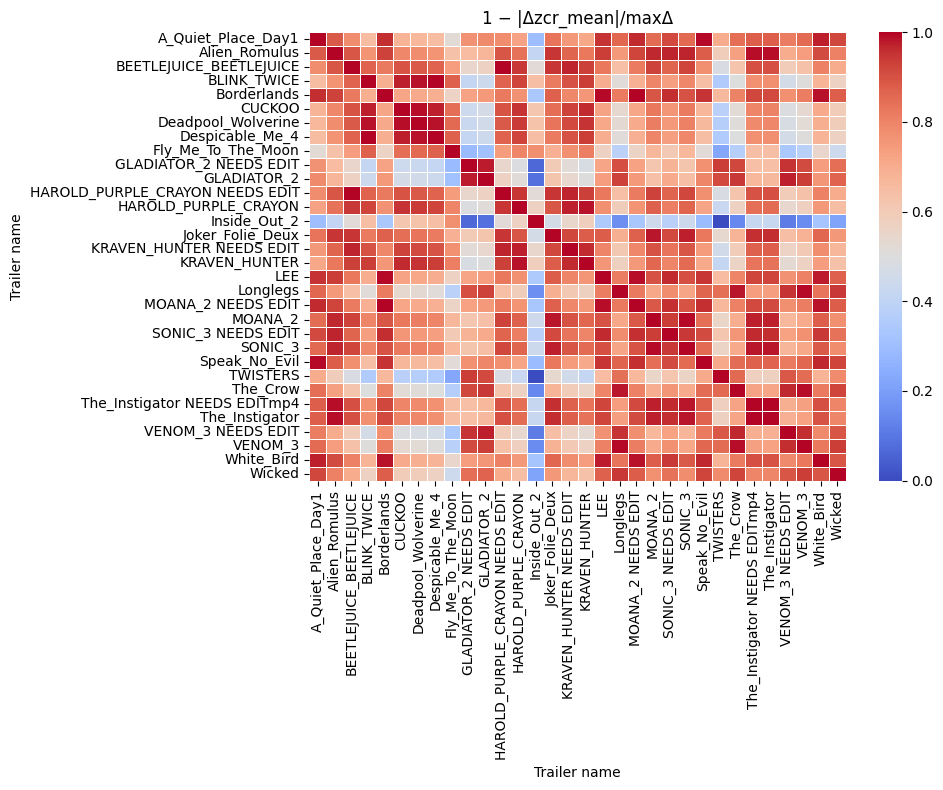

In [17]:
feat = "zcr_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δzcr_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

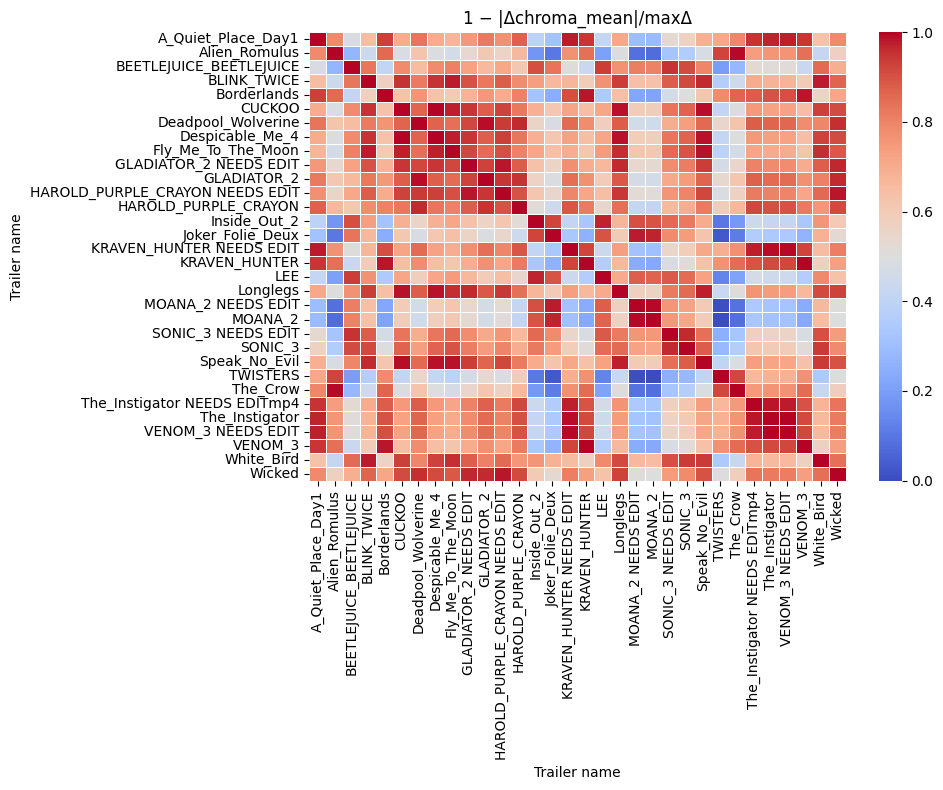

In [18]:
feat = "chroma_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δchroma_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

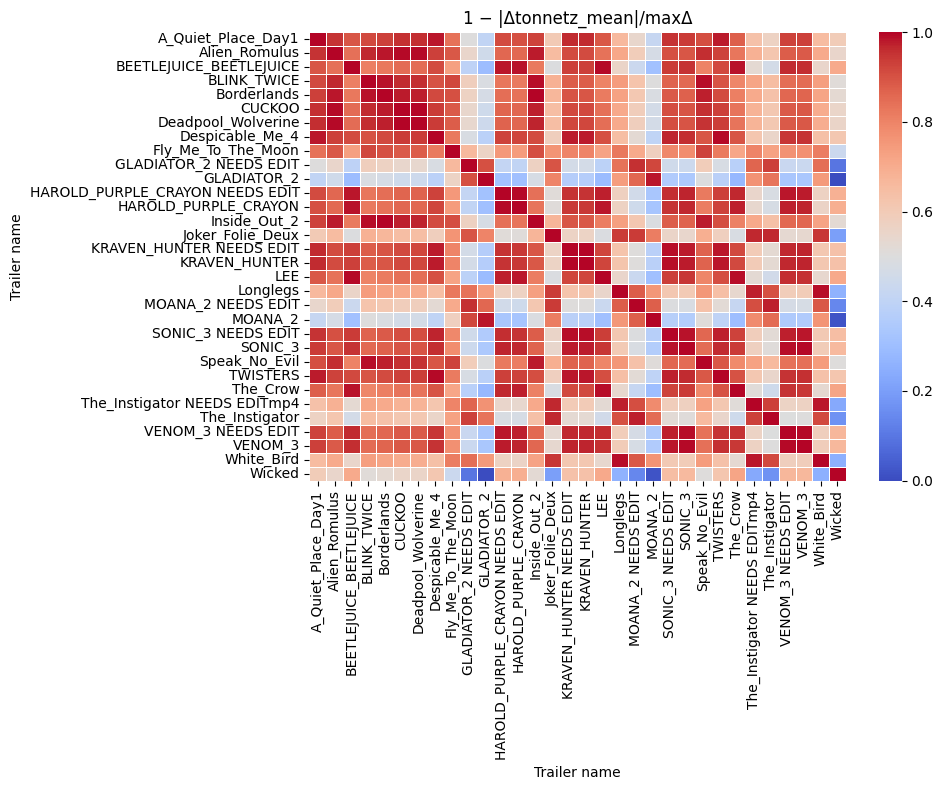

In [19]:
feat = "tonnetz_mean"
vals = df_audio[feat].values.reshape(-1,1)

diff = np.abs(vals - vals.T)

max_diff = diff.max()
sim = 1 - (diff / max_diff)
sim_df = pd.DataFrame(sim, index=df_audio.index, columns=df_audio.index)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, cmap="coolwarm", vmin=0, vmax=1, linewidths=0.5)
plt.title("1 − |Δtonnetz_mean|/maxΔ")
plt.xlabel("Trailer name")
plt.ylabel("Trailer name")
plt.tight_layout()
plt.show()

In [20]:
import os
import requests
import mne
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

AUDIO_WIN_CSV  = "audio_sliding_features.csv"
CHUNK_DURATION = 0.96

RAW_EEG_FIF  = "subj01_raw.fif"
EVENTS_FIF   = "subj01-events.fif"

In [21]:

np.complex = complex


audio_output_dir = os.path.expanduser("~/derivatives/audio")

sr_target  = 16000
n_fft      = 2048
hop_length = 512

records = []
for fname in sorted(os.listdir(audio_output_dir)):
    if not fname.lower().endswith(".wav"):
        continue
    trailer = os.path.splitext(fname)[0]
    path    = os.path.join(audio_output_dir, fname)

    y, sr      = librosa.load(path, sr=sr_target)
    y_harmonic = librosa.effects.harmonic(y)
    
    mfcc      = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13,
                                     n_fft=n_fft, hop_length=hop_length)
    centroid  = librosa.feature.spectral_centroid(y=y, sr=sr,
                                                   n_fft=n_fft, hop_length=hop_length)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr,
                                                   n_fft=n_fft, hop_length=hop_length)
    contrast  = librosa.feature.spectral_contrast(y=y, sr=sr,
                                                  n_fft=n_fft, hop_length=hop_length)
    flatness  = librosa.feature.spectral_flatness(y=y,
                                                  n_fft=n_fft, hop_length=hop_length)
    rms       = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    zcr       = librosa.feature.zero_crossing_rate(y=y,
                                                   frame_length=n_fft, hop_length=hop_length)
    chroma    = librosa.feature.chroma_stft(y=y, sr=sr,
                                            n_fft=n_fft, hop_length=hop_length)
    tonnetz   = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    
    n_frames = mfcc.shape[1]
    times    = librosa.frames_to_time(np.arange(n_frames),
                                      sr=sr, hop_length=hop_length)
    
    df_w = pd.DataFrame({
        "trailer":    trailer,
        "start_time": times,
        "mfcc":       mfcc.mean(axis=0),
        "centroid":   centroid[0],
        "bandwidth":  bandwidth[0],
        "contrast":   contrast.mean(axis=0),
        "flatness":   flatness[0],
        "rms":        rms[0],
        "zcr":        zcr[0],
        "chroma":     chroma.mean(axis=0),
        "tonnetz":    tonnetz.mean(axis=0),
    })
    records.append(df_w)

df_windows = pd.concat(records, ignore_index=True)

print(df_windows.columns.tolist())
df_windows.head()


['trailer', 'start_time', 'mfcc', 'centroid', 'bandwidth', 'contrast', 'flatness', 'rms', 'zcr', 'chroma', 'tonnetz']


trailer  start_time       mfcc     centroid    bandwidth  \
0  A_Quiet_Place_Day1       0.000 -37.730736     0.000000     0.000000   
1  A_Quiet_Place_Day1       0.032 -37.730736  1236.125310  1582.962625   
2  A_Quiet_Place_Day1       0.064 -36.886936   747.615502   804.263779   
3  A_Quiet_Place_Day1       0.096 -37.940903  1026.588639  1077.537906   
4  A_Quiet_Place_Day1       0.128 -37.931820   993.296243   998.474301   

    contrast  flatness       rms       zcr    chroma   tonnetz  
0  13.108590  1.000001  0.000000  0.000000  0.000000 -0.037176  
1  13.200675  0.010851  0.000292  0.009766  0.283745 -0.043416  
2  18.529247  0.000121  0.002831  0.028809  0.136401 -0.020697  
3  19.364766  0.000275  0.004449  0.048340  0.122749  0.016615  
4  20.802142  0.000222  0.005236  0.069336  0.128052  0.005160

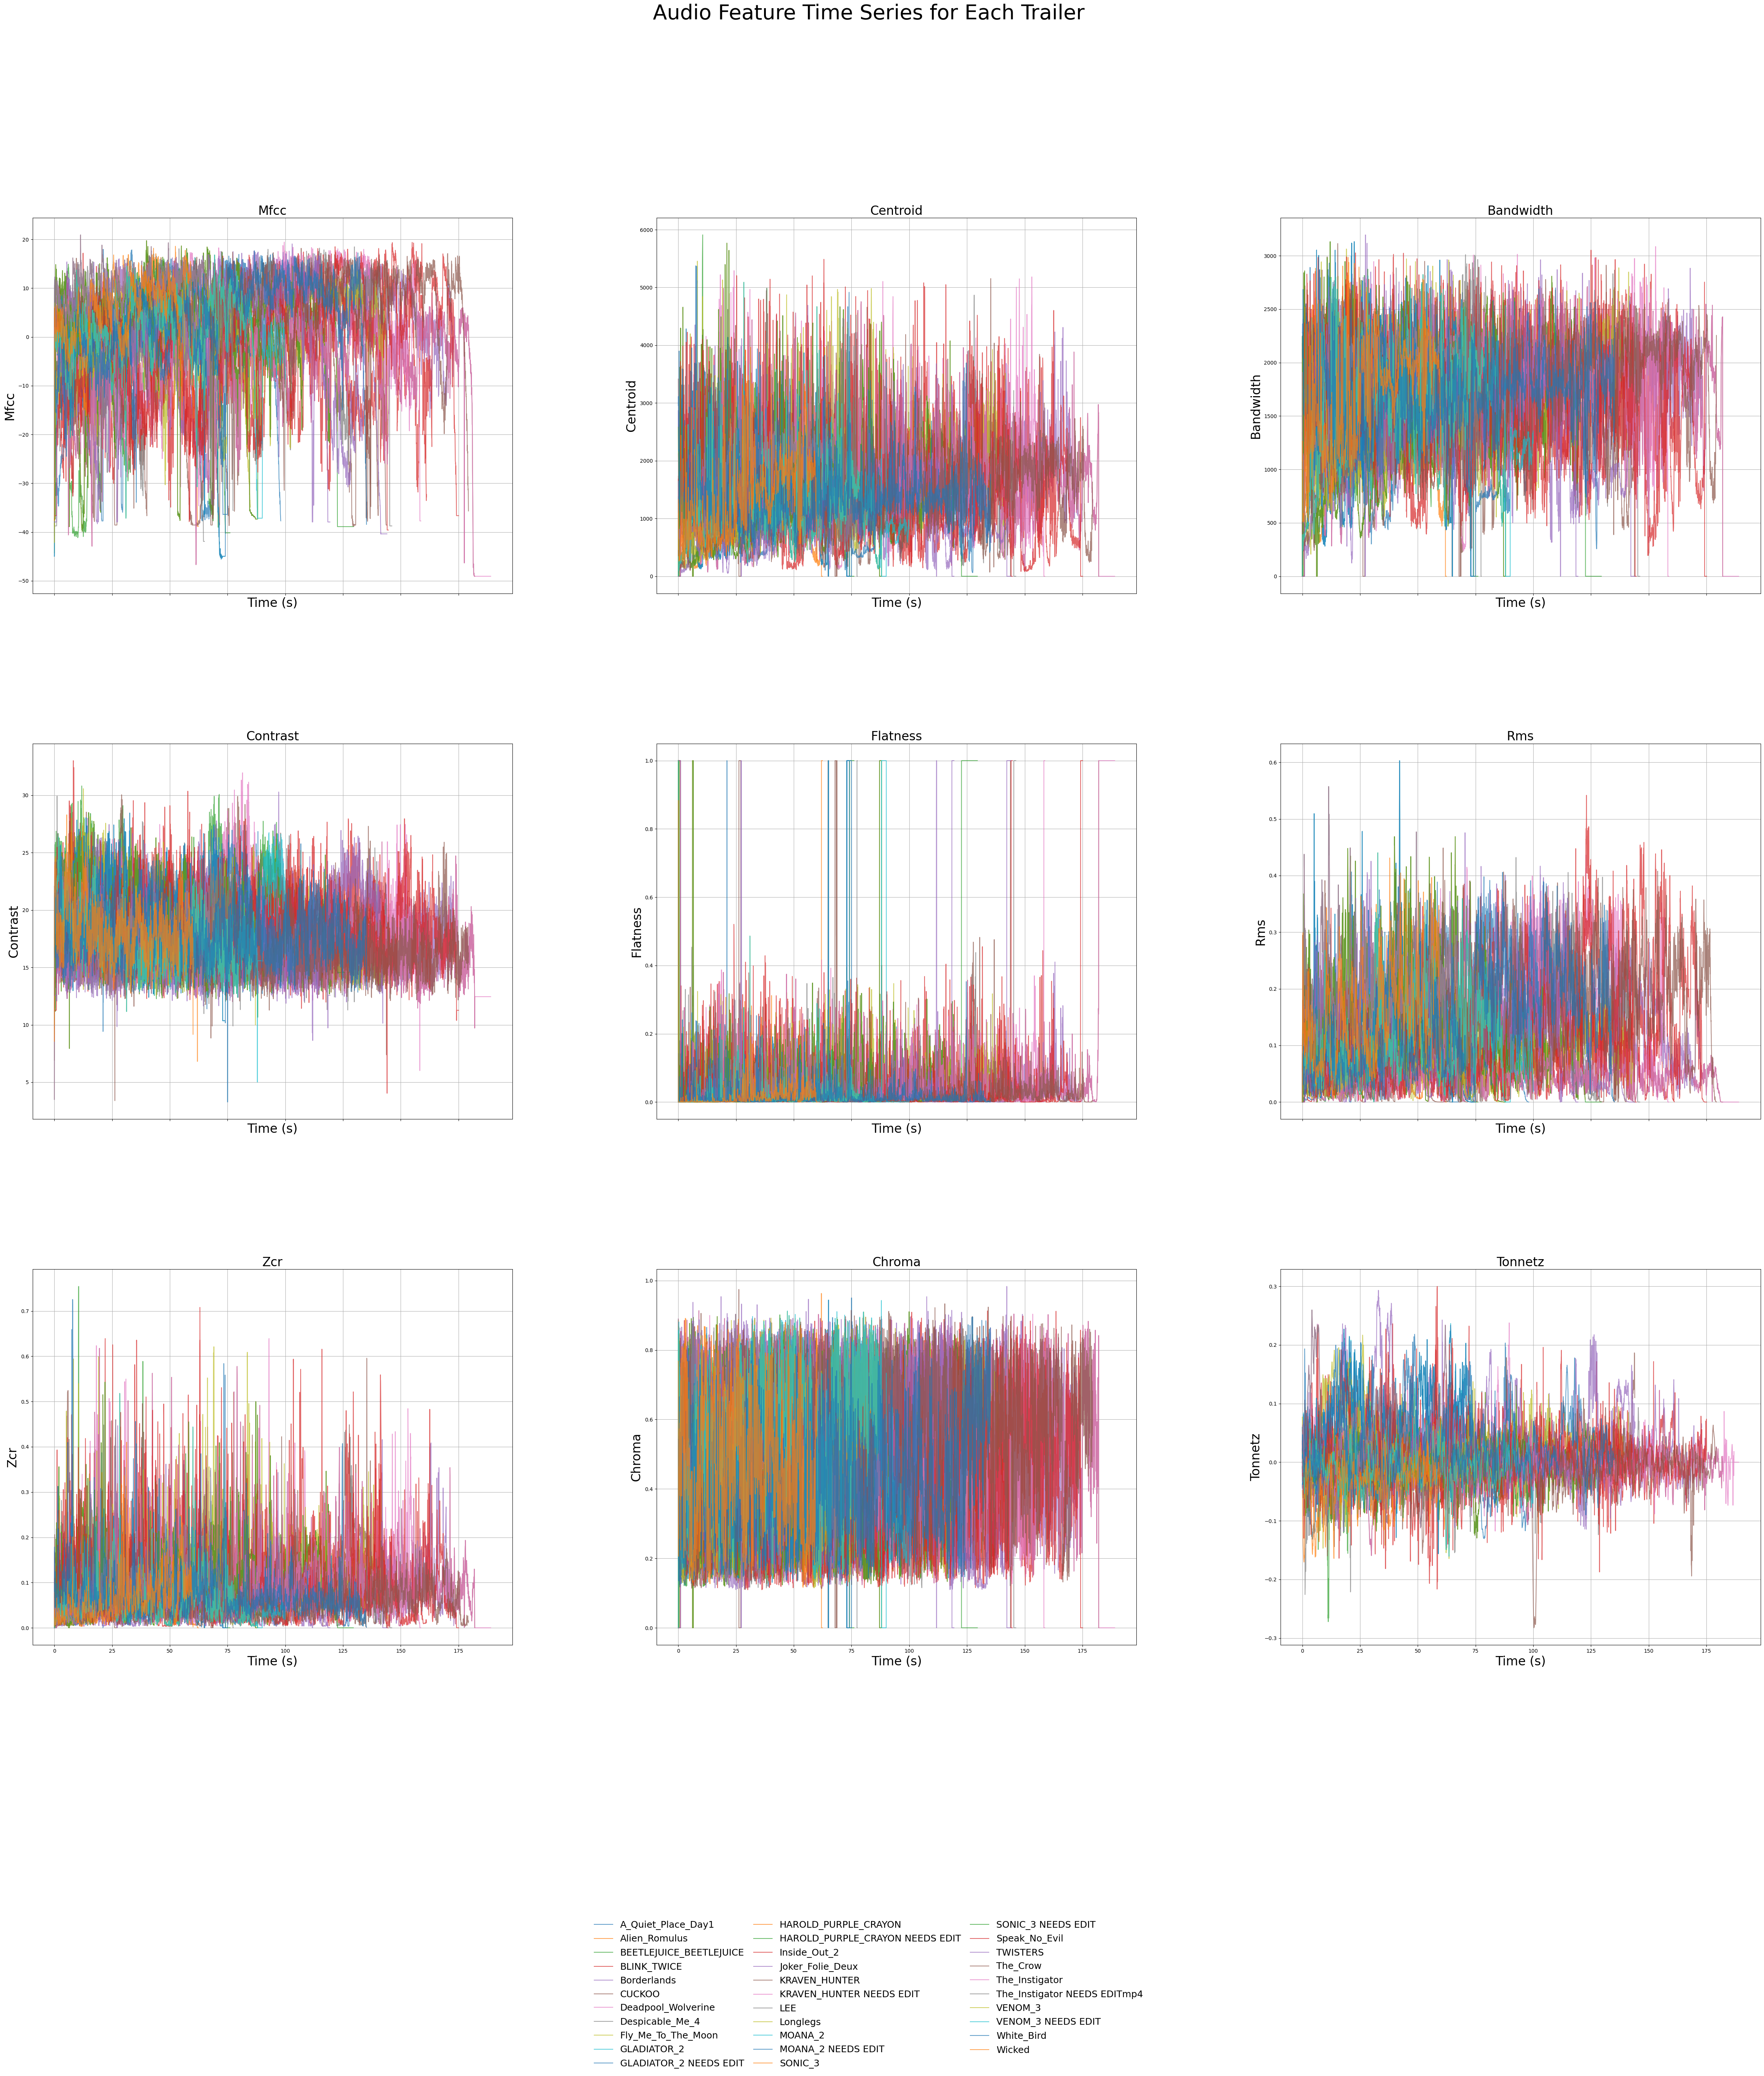

In [22]:

features = [
    "mfcc",
    "centroid",
    "bandwidth",
    "contrast",
    "flatness",
    "rms",
    "zcr",
    "chroma",
    "tonnetz",
]

trailers = df_windows["trailer"].unique()

fig, axes = plt.subplots(3, 3, figsize=(60, 48), sharex=True, sharey=False)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    for title, grp in df_windows.groupby("trailer"):
        ax.plot(grp["start_time"], grp[feat], label=title, alpha=0.7)
    ax.set_title(feat.title(), fontsize=24)
    ax.set_xlabel("Time (s)", fontsize=24)
    ax.set_ylabel(feat.title(), fontsize=24)
    ax.grid(True)

for ax in axes[len(features):]:
    fig.delaxes(ax)

handles, labels = axes[0].get_legend_handles_labels()

fig.legend(
    handles, labels,
    loc="lower center",
    ncol=3,                     
    bbox_to_anchor=(0, -0.15, 1.0, 0.15),
    fontsize=18,                
    handlelength=2,
    labelspacing=0.5,           
    columnspacing=1,                     
    borderaxespad=2,      
    frameon=False 
)

plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4, wspace=0.3)
plt.suptitle("Audio Feature Time Series for Each Trailer", fontsize=40, y=1.02)
plt.show()
